# Imports and Function Definitions

In [78]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.autonotebook import tqdm as tqdm_jupyter
from tqdm import tqdm as tqdm_bash
import inspect
import os
import time
from siamese_tools import *
import matplotlib.pyplot as plt
import matplotlib
import itertools
from queue import Queue
import pandas as pd
import random
import json
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import hdbscan


In [2]:
def dist(tens1,tens2,scalar=1):
    # This is the distance function used in training and testing with pytorch
    tens1 = (tens1.type(torch.cuda.DoubleTensor)*scalar).cpu().numpy().astype(np.longdouble)
    tens2 = (tens2.type(torch.cuda.DoubleTensor)*scalar).cpu().numpy().astype(np.longdouble)
    sub = tens1-tens2
    sqr = np.power(sub,2)
    s = np.sum(sqr,axis=1)
    dis = np.power(s,0.5)
    return dis

def print_stats(x,y):
    # This prints out statistics about the performance of a binary classification
    conf_m = confusion_matrix(x,y)
    print("       precision: {0:.4f}".format(precision_score(x,y)))
    print("        accuracy: {0:.4f}".format(accuracy_score(x,y)))
    print("        f1 score: {0:.4f}".format(f1_score(x,y)))
    print("           recal: {0:.4f}".format(recall_score(x,y)))
    print("confusion matrix: [{}\n                  {}]".format(conf_m[0],conf_m[1]))

def euclidean_distance(a,b):
    # Fast euclidean distance
    # Modified from: https://stackoverflow.com/a/47775357/6454085
    a_min_b = a - b
    return np.sqrt(np.einsum("ij,ij->j", a_min_b, a_min_b))

# Settings for Validation
## Base CNN Settings

The initial model that I trained used a simple CNN network. These are the settings that should be used to evaluate it. It was not trained for as long as it should have been, so the performance is not fantastic. I would highly recommend using the SiameseResNet Model

In [3]:
model_name = "skw.base_cnn.v1"
epochs = 20
batch_size = 64
pbar_type = "jupyter"
image_type = "L"
model_path = os.path.join("models",model_name+".ep_"+str(epochs),"epoch_19.pt")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
model_class = SiameseNetwork

## Base SiameseResNet
These are the settings to evaluate the SiameseResNet model that I trained. I think that it could have used a few more epochs, and some more data (PyTorch data augmentation?), but it performs decently.

In [4]:
model_name = "skw.base_resnet.v1"
epochs = 20
batch_size = 64
pbar_type = "jupyter"
image_type = "RGB"
model_path = os.path.join("models",model_name+".ep_"+str(epochs),"best.pt")
transformation = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
model_class = SiameseResNet

In [164]:
root_dir = "data"
test_dir = os.path.join(root_dir,"test")

im_test_dset = dset.ImageFolder(root=test_dir,transform=transformation)
classes = ["curb ramp","missing curb ramp","obstruction","surface problem","null"]
#index_to_class_name = dict([(value, key) for key, value in im_test_dset.class_to_idx.items()])
index_to_class_name = dict((i,classes[i]) for i in range(len(classes)))

val_loader = DataLoader(im_test_dset,shuffle=True,num_workers=0,batch_size=batch_size)

loss_function = ContrastiveLoss()
print("CUDA availability:",torch.cuda.is_available())
print("Using model:", model_path)

CUDA availability: True
Using model: models\skw.base_resnet.v1.ep_20\best.pt


# Calculate Siamese Vectors for each image

In order to accurately gauge peformance, I start by running each of the testing images through the siamese network and saving the resulting vectors. This takes a lot of time so it should ideally only have to be run once.

After all the vectors are calculated, several tests are performed in later cells to evaluate the model.

In [29]:
model = model_class()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
val_batches = len(val_loader)

preds = []
first = True

model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

loss_function = ContrastiveLoss()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
with torch.no_grad():
    progress = None
    if pbar_type == "bash":
        progress = tqdm_bash(enumerate(val_loader,0), total=val_batches, unit=" batch(es)", position=0, leave=True)
    if pbar_type == "jupyter":
        progress = tqdm_jupyter(enumerate(val_loader,0), total=val_batches, unit=" batch(es)")
    prev_data = []
    for i,data in progress:
        if i%2 == 0:
            prev_data = data
            
        else:
            img0,img0_class = data
            img1,img1_class = prev_data
            img0, img1 = img0.to(device), img1.to(device)

            output0, output1 = model(img0,img1)
            for j in range(len(output1)):
                if first:
                    first = False
                    preds = np.array([[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]])
                    preds = np.append(preds, [[output1[j].cpu().numpy(),img1_class[j].cpu().numpy()]],axis=0)
                else:
                    preds = np.append(preds, [[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]],axis=0)
                    preds = np.append(preds, [[output1[j].cpu().numpy(),img1_class[j].cpu().numpy()]],axis=0)
            prev_data = -1

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    if prev_data != -1:
        img1,img1_class = prev_data
        img1 = img1.to(device)

        output0, output1 = model(img1,img1)
        for j in range(len(output1)):
            if first:
                preds = np.array([[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]])
            else:
                preds = np.append(preds, [[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]],axis=0)
        prev_data = -1

C:\Users\LionHeart\Anaconda2\envs\Project Sidewalk\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [57]:
processed_preds = []
first = True
for i in preds:
    if first:
        processed_preds = [np.append(i[1],i[0])]
        first = False
    else:
        processed_preds = np.append(processed_preds, [np.append(i[1],i[0])],axis=0)
np.savetxt(model_name+".validations.csv", processed_preds, delimiter=',')

## Undersample the dataset to balance it

Ideally, each vector would be compared against every other vector to get the most inclusive metrics, but that would be upwards of 900 million comparisons with the amount of testing data I currently have. Instead, I decided to undersample the dataset until it was balanced.

In [10]:
df = pd.read_csv(model_name+".validations.csv",header=None,dtype=np.float64)
df.insert(0,"index",df.index)
filtered_vectors = []
unique_classes = df[0].unique()
print("Using classes {}".format(unique_classes))
min_len = -1
for c in unique_classes:
    c_len = len(df[df[0] == c])
    if min_len < 0 or min_len > c_len:
        min_len = c_len
for c in unique_classes:
    filtered_class = df[df[0]==c].values.tolist()
    np.random.shuffle(filtered_class)
    filtered_vectors += filtered_class[:min_len]
filtered_vectors = np.array(filtered_vectors)
num_combs = len(list(itertools.combinations(filtered_vectors, 2)))
print('{} total comparisons'.format(num_combs))

Using classes [0. 3. 4. 1. 2.]
19310005 total comparisons


## Make distance comparisons between each combination of vectors

Now, I compare each vector's distance with every other vector. This also takes along time and results in a multi-gigabyte file. Again, it should ideally only be run once.

Additionally, for each vector, I store the sum of it's distances with every vector in each other class, and the sum of it's distances with every vector in it's own class. This will be used later when picking a support set for multi-class classification

In [7]:
if pbar_type == "bash":
    progress = tqdm_bash(enumerate(itertools.combinations(filtered_vectors, 2)), total=num_combs, unit=" comparison(s)", position=0, leave=True)
if pbar_type == "jupyter":
    progress = tqdm_jupyter(enumerate(itertools.combinations(filtered_vectors, 2)), total=num_combs, unit=" comparison(s)")

distances = []
last3 = []
distance_per_vector = dict([(int(value), [0,0]) for value in filtered_vectors[:,0]])
for i,comb in progress:
    last3.append(comb)
    if i % 3 == 2:
        a = np.zeros((3,len(comb[0][2:])))
        b = np.zeros((3,len(comb[0][2:])))
        for j in range(3):
            a[j] = last3[j][0][2:]
            b[j] = last3[j][1][2:]
        dsts = euclidean_distance(a.T,b.T)
        for j in range(3):
            comparison = np.concatenate([[dsts[j]],[last3[j][0][1]],[last3[j][1][1]]])
            distances.append(comparison)
            if last3[j][0][1] == last3[j][1][1]:
                distance_per_vector[last3[j][0][0]][0] += dsts[j]
                distance_per_vector[last3[j][1][0]][0] += dsts[j]
            else:
                distance_per_vector[last3[j][0][0]][1] += dsts[j]
                distance_per_vector[last3[j][1][0]][1] += dsts[j]
        last3 = []

In [50]:
df_dist = pd.DataFrame(distances,columns=['distance','class1','class2'])
df_dist.to_csv(model_name+'.comparisons.csv', index=False)

with open(model_name+'.distance_per_vector.json', 'w') as f:
    json.dump(distance_per_vector, f)

# Evaluate Siamese Nets for Binary Classification

The two following histograms should ideally be bimodal. If two vectors in the same class are compared, they should have a small distance, and if two vectors in different classes are compared, they should have a large distance.

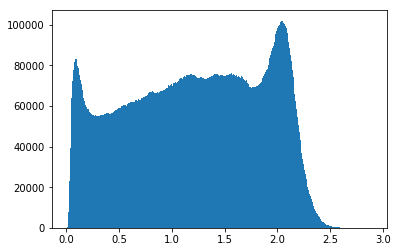

In [8]:
distance_per_vector = {}
with open(model_name+'.distance_per_vector.json') as f:
    distance_per_vector = json.load(f)

df_dist = pd.read_csv(model_name+".comparisons.csv")
plt.hist(df_dist['distance'], bins='auto')
plt.show()

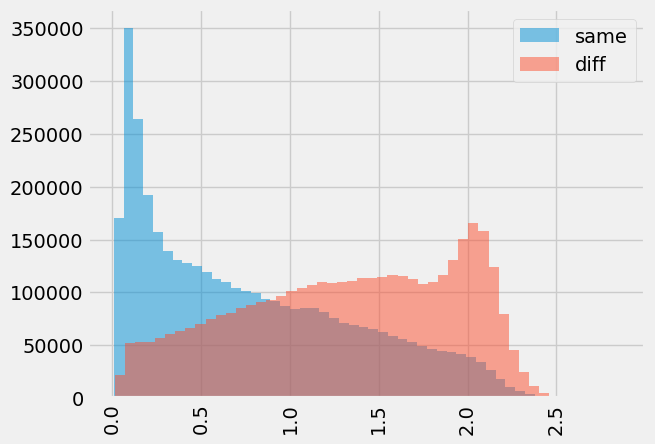

In [174]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('fivethirtyeight')#'ggplot')

same = df_dist[df_dist['class1'] == df_dist['class2']]['distance']
diff_large = df_dist[df_dist['class1'] != df_dist['class2']]['distance']

diff = diff_large.values.tolist()
d_part = len(diff)/len(same)
np.random.shuffle(diff)
diff = pd.Series(diff[:int(len(diff)/d_part)])

bins = 50
plt.hist(same, bins, alpha=0.5, label='same')
plt.hist(diff, bins, alpha=0.5, label='diff')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.savefig(model_name+".ep_"+str(epochs)+".full_test"+".png", bbox_inches='tight')
plt.show()

The two following cells calculate a cutoff value for the distance between two vectors. Any pair vectors that have a distance smaller than that value will be labeled as in the same class, and any pair vectors that have a distance larger than that value will be labeled as in different classes.

In [37]:
step_size = 0.0001
mid = np.mean(df_dist['distance'])
rng = max(df_dist['distance'])/6
cutoffs = np.arange(mid-rng,mid+rng,step_size)
print("Checking "+str(len(cutoffs))+" clipping values from {0:.2f} to {1:.2f} in increments of ".format(mid-rng,mid+rng)+str(step_size))
sames = np.array([])
diffs = np.array([])

if pbar_type == "bash":
    progress = tqdm_bash(cutoffs, total=len(cutoffs), unit=" comparison(s)", position=0, leave=True)
if pbar_type == "jupyter":
    progress = tqdm_jupyter(cutoffs, total=len(cutoffs), unit=" comparison(s)")

for cutoff in progress:
    sames = np.append(sames,sum(same[same<cutoff]))
    diffs = np.append(diffs,np.sum(diff[diff>cutoff]))

Checking 9684 clipping values from 0.73 to 1.70 in increments of 0.0001


In [64]:
cutoff = cutoffs[np.argmax(sames+diffs)]
preds = df_dist['distance'].values.tolist()
lbls = np.where(df_dist['class1'] == df_dist['class2'],0,1)
thresh_preds = np.zeros(len(preds))
for i in range(len(preds)):
    if preds[i] > cutoff:
        thresh_preds[i] = 1
print("Using a cutoff of {0:.4f}".format(cutoff))
print_stats(thresh_preds,lbls)

Using a cutoff of 0.8634
       precision: 0.7409
        accuracy: 0.7136
        f1 score: 0.8054
           recal: 0.8822
confusion matrix: [[2331533 4003141]
                  [ 1527981 11447349]]


# Evaluate Siamese Nets for Multi-Class Classification
## Generate support set

Using siamese nets for multi-class classification is much harder than for binary classification. For each class, a set of support vectors need to be chosen. Then a user asks the model to classify an image, it generates the vector for that image, and compares it against each vector in the support set. The support vector that the input image was closest to is the class that it is in.

I implemented 3 methods to pick the support set.
- Take the average of each vector in that class
- Use the distances calculated earlier to find the mathematically best n vectors for each class
- Break each class into clusters and use the mathematically best vector in each cluster

Additionally, I also tried to train an SVM to predict classes based on the siamese output vectors to eliminate the need for a support set. This performed better on some classes and worse on others, so I went back to support vectors.

Overall, I found that I got the best performance by using the best ~100 vectors from each class as the support set.

In [158]:
class_vectors = {}
class_name_to_index = {}
num_support_set_per_class = 100

methods = {'average':0, 'best-n':1, 'clusters':2}
method = methods['best-n']

for i,c in enumerate(np.sort(unique_classes)):
    class_vec = []
    
    # Use the average vector for each class
    if method == 0:
        class_vec = np.average([vec[1:] for vec in df[df[0]==c].values.tolist()], axis=0)
        
    # Use the best n vectors for each class
    if method == 1:
        to_check = [str(int(col[0])) for col in df[df[0]==c].values.tolist()]

        scores = [0]*len(to_check)
        for j,idx in enumerate(to_check):
            if idx in distance_per_vector:
                scores[j] = (distance_per_vector[idx][1] - (len(index_to_class_name)*distance_per_vector[idx][0]))
        best_idxs = [int(to_check[vec]) for vec in np.argsort(scores)[-num_support_set_per_class:]]
        best_vecs = df[df['index'].isin(best_idxs)].values.tolist()

        if num_support_set_per_class == 1:
            class_vec = best_vecs[0][2:]
        else:
            class_vec = [vec[2:] for vec in best_vecs]
    
    # Use the centroid of each cluster within a class
    if method == 2:
        to_check = np.array([col for col in df[df[0]==c].values.tolist()])
        ids_to_check = [str(int(col[0])) for col in df[df[0]==c].values.tolist()]
        clusterer = hdbscan.HDBSCAN()
        clusterer.fit(to_check)
        
        clusters = dict((cluster,[]) for cluster in np.unique(clusterer.labels_))
        for i,cluster in enumerate(clusterer.labels_):
            clusters[cluster].append(ids_to_check[i])
        for cluster in clusters:
            cluster_scores = []
            if cluster != -1:
                for idx in clusters[cluster]:
                    if idx in distance_per_vector:
                        cluster_scores.append(distance_per_vector[idx][1] - (len(index_to_class_name)*distance_per_vector[idx][0]))
                try:
                    best_idx = [int(ids_to_check[vec]) for vec in np.argsort(cluster_scores)][-1]
                    class_vec.append(df[df['index'] == best_idx].values.tolist()[0][2:])
                except:
                    pass
        class_vec = np.array(class_vec)
        
        # Use the centroid of each cluster
        #clf = NearestCentroid()
        #clf.fit(to_check,clusterer.labels_)
        #if -1 in clusterer.labels_:
        #    class_vec = clf.centroids_[1:]
        #else:
        #    class_vec = clf.centroids_
    
    class_vectors[c] = class_vec
    class_name_to_index[index_to_class_name[c]] = i

In [160]:
distances = np.zeros((len(df.values.tolist()),len(class_vectors)))
lbls = np.array([])
if num_support_set_per_class == 1:
    b = np.array(list(class_vectors.values()))
    for i,comb in enumerate(df.values.tolist()):
        lbls = np.append(lbls,comb[1])
        a = np.tile([comb[2:]],(len(class_vectors),1))
        dsts = euclidean_distance(a.T,b.T)
        distances[i] = dsts
    lbls = lbls.astype(int)
else:
    b = np.array(list(class_vectors.values()))
    for i,comb in enumerate(df.values.tolist()):
        lbls = np.append(lbls,comb[1])
        for j in range(b.shape[0]):
            a = np.tile([comb[2:]],(b[j].shape[0],1))
            dst = np.mean(euclidean_distance(a.T,b[j].T))
            distances[i][j] = dst
    lbls = lbls.astype(int)

In [166]:
multi_class_preds = np.argmin(distances,axis=1)
print(classification_report(multi_class_preds, lbls, target_names=list(index_to_class_name.values())))

                   precision    recall  f1-score   support

        curb ramp       0.89      0.89      0.89     18764
missing curb ramp       0.34      0.39      0.37      2255
      obstruction       0.61      0.67      0.64      2940
  surface problem       0.37      0.19      0.25      2411
             null       0.84      0.86      0.85     16160

         accuracy                           0.80     42530
        macro avg       0.61      0.60      0.60     42530
     weighted avg       0.79      0.80      0.79     42530



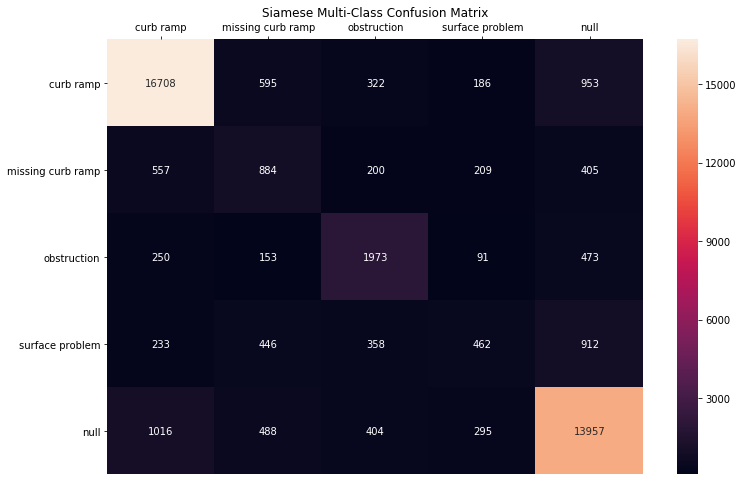

In [168]:
%matplotlib inline
plt.figure(figsize=[2*x for x in plt.rcParams["figure.figsize"]])
confusion = confusion_matrix(multi_class_preds, lbls)
df_cm = pd.DataFrame(confusion, index = list(index_to_class_name.values()),columns = list(index_to_class_name.values()))
ax = sns.heatmap(df_cm,annot=True,fmt="d")
plt.title("Siamese Multi-Class Confusion Matrix")
ax.xaxis.set_ticks_position('top')

# Train and Test SVM on Siamese Outputs for Multi-Class Classification

This is the code mentioned earlier where I used an SVM to predict classes based on the siamse outputs to eliminate the need for support vectors.

In [170]:
unfiltered_vectors = df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split([vec[2:] for vec in unfiltered_vectors], [vec[1] for vec in unfiltered_vectors], test_size=0.2, shuffle=True)

print("Train Set distrubution:")
for c in np.unique(y_train):
    print(" {}: {}".format(list(index_to_class_name.values())[int(c)],y_train.count(c)))
print()
print("Test Set distrubution:")
for c in np.unique(y_test):
    print(" {}: {}".format(list(index_to_class_name.values())[int(c)],y_test.count(c)))

classifier = SVC(class_weight="balanced")

Train Set distrubution:
 curb ramp: 15025
 missing curb ramp: 2058
 obstruction: 2597
 surface problem: 990
 null: 13354

Test Set distrubution:
 curb ramp: 3739
 missing curb ramp: 508
 obstruction: 660
 surface problem: 253
 null: 3346


In [171]:
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [172]:
SVC_preds = classifier.predict(X_test)
print(classification_report(SVC_preds, y_test, target_names=list(index_to_class_name.values())))

                   precision    recall  f1-score   support

        curb ramp       0.89      0.89      0.89      3740
missing curb ramp       0.16      0.40      0.23       207
      obstruction       0.70      0.61      0.65       761
  surface problem       0.49      0.20      0.29       615
             null       0.83      0.87      0.85      3183

         accuracy                           0.80      8506
        macro avg       0.61      0.59      0.58      8506
     weighted avg       0.80      0.80      0.79      8506



# Visualize Siamese Outputs with tSNE and UMAP

The SiameseResNet model returns a vector of length 128 for each image. That is very hard to visualize on its own, so in the following cells, I used tSNE and UMAP (both common techniques for visualizing high dimensional data) to help myself better understand what the SiameseResNet was doing and how it affected performance.

In [58]:
from mpl_toolkits.mplot3d import Axes3D

vectors = [vec[2:] for vec in filtered_vectors]
tsne = TSNE(n_components=3, verbose=1, perplexity=250, n_iter=5000)
tsne_results = tsne.fit_transform(vectors)

[t-SNE] Computing 751 nearest neighbors...
[t-SNE] Indexed 6215 samples in 0.031s...
[t-SNE] Computed neighbors for 6215 samples in 4.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6215
[t-SNE] Computed conditional probabilities for sample 2000 / 6215
[t-SNE] Computed conditional probabilities for sample 3000 / 6215
[t-SNE] Computed conditional probabilities for sample 4000 / 6215
[t-SNE] Computed conditional probabilities for sample 5000 / 6215
[t-SNE] Computed conditional probabilities for sample 6000 / 6215
[t-SNE] Computed conditional probabilities for sample 6215 / 6215
[t-SNE] Mean sigma: 0.058579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.595684
[t-SNE] KL divergence after 2450 iterations: 0.365284


<IPython.core.display.Javascript object>


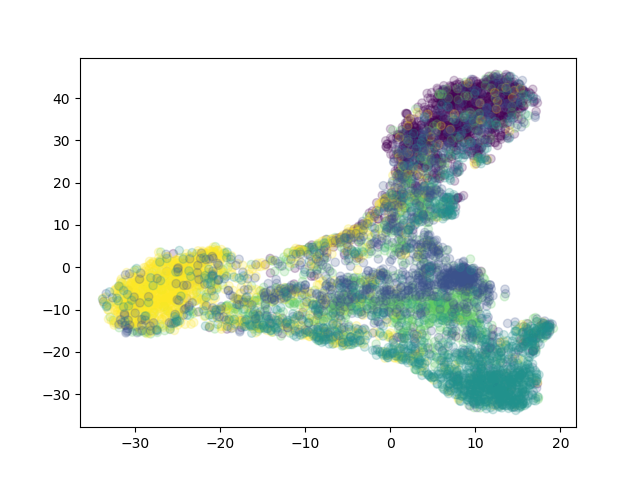

In [57]:
plt.figure()
plt.scatter(tsne_results[:,0], tsne_results[:,1],c=c,alpha=0.2)
plt.show()

<IPython.core.display.Javascript object>


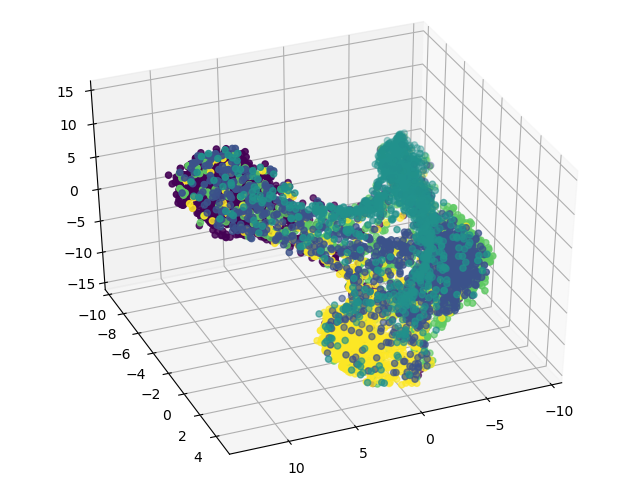

In [62]:
%matplotlib notebook
c = [vec[1] for vec in filtered_vectors]

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2],c=c)
plt.show()

In [41]:
u = UMAP(n_components=2, metric='euclidean', min_dist=0.15, n_neighbors=500)
embedding = u.fit_transform(vectors)

C:\Users\LionHeart\Anaconda2\envs\Project Sidewalk\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "C:\Users\LionHeart\Anaconda2\envs\Project Sidewalk\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


<IPython.core.display.Javascript object>


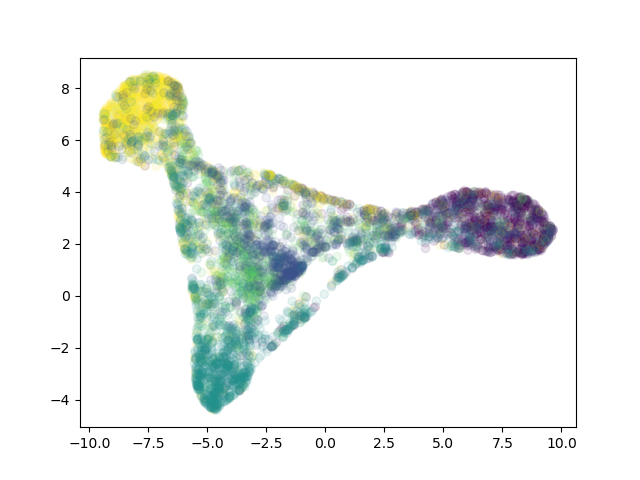

In [42]:
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=c, alpha=0.1)

## Clustering within Classes

One of the ways that I picked support vectors was through clustering within classes. To help myself better visualize what was going on, I again used tSNE to reduce the dimensionality of each class so that I could see the clusters

In [83]:
class_clusters = []
for c in np.sort(unique_classes):
    to_check = np.array([col[2:] for col in df[df[0]==c].values.tolist()])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=int(len(to_check)/100))
    clusterer.fit(to_check)
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300)
    tsne_results = tsne.fit_transform(to_check)
    class_clusters.append([tsne_results,clusterer.labels_])

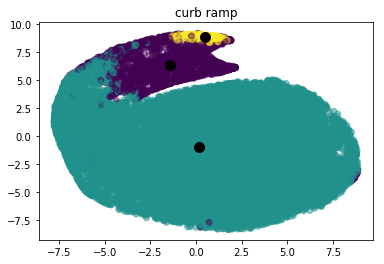

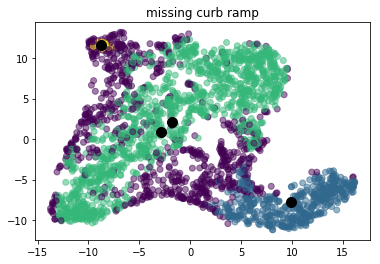

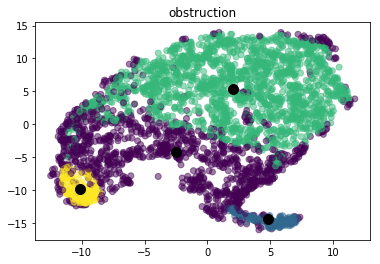

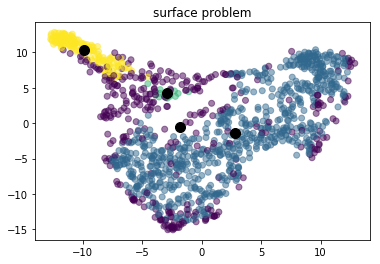

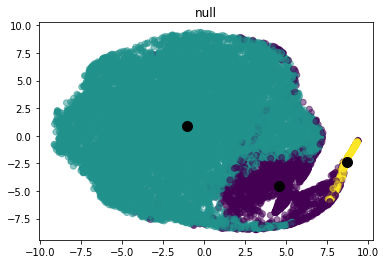

In [173]:
for i,c in enumerate(class_clusters):
    plt.figure()
    plt.title(index_to_class_name[np.sort(unique_classes)[i]])
    x = c[0][:,0]
    y = c[0][:,1]
    plt.scatter(x, y,c=c[1],alpha=0.5)
    
    clf = NearestCentroid()
    clf.fit(c[0],c[1])
    plt.scatter(clf.centroids_[:,0],clf.centroids_[:,1],c='black',s=100)
    plt.show()